### CIFAR10 Pretrained Model
- VGG16
- ResNet50V2
- Xception

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# set seed
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# scaling
def get_preprocessed_data(images, labels, scaling=True):
    
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)
    
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

# ohe
def get_preprocessed_ohe(images, labels):
    
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    
    oh_labels = to_categorical(labels)
    
    return images, oh_labels

# dataset split
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    
    train_images, train_oh_labels = \
        get_preprocessed_ohe(train_images, train_labels)
    
    test_images, test_oh_labels = \
        get_preprocessed_ohe(test_images, test_labels)
    
    tr_images, val_images, tr_oh_labels, val_oh_labels = \
        train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)
    

In [2]:
# resize
def get_resized_images(images, resize=64):
    
    # image data batch size
    image_cnt = images.shape[0]
    
    resized_images = np.zeros((images.shape[0], resize, resize, 3))
    
    for i in range(image_cnt):
        resized_image = cv2.resize(images[i], (resize, resize))
        resized_images[i] = resized_image
    
    return resized_images

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

def create_model(model_name='vgg16', verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    base_model_output = base_model.output
    
    x = GlobalAveragePooling2D()(base_model_output)
    
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    
    x = Dense(50, activation='relu', name='fc1')(x)
    output = Dense(10, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
    
    return model

In [4]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

In [5]:
def do_cifar10_train_evaluation(image_size=IMAGE_SIZE, model_name='vgg16'):
    
    # set seed
    set_random_seed(2021)
    
    # data_load
    (train_images, train_labels), (test_images, test_labels) = \
        cifar10.load_data()
    
    # data preprocessing
    (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
        get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)
    
    print('train dataset shape: ', tr_images.shape, tr_oh_labels.shape)
    print('validation dataset shape: ', val_images.shape, val_oh_labels.shape)
    print('test dataset shape: ', test_images.shape, test_oh_labels.shape)
    
    # resize
    if image_size > 32:
        tr_images = get_resized_images(tr_images)
        val_images = get_resized_images(val_images)
        test_images = get_resized_images(test_images)
    
    # ImageDataGenerator
    train_generator = ImageDataGenerator(
        horizontal_flip=True,
        rescale=1/255.0
    )
    valid_generator = ImageDataGenerator(rescale=1/255.0)
    test_generator = ImageDataGenerator(rescale=1/255.0)
    
    # flow pipeline
    flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
    flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
    flow_test_gen = train_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
    
    # model create
    model = create_model(model_name=model_name, verbose=True)
    
    # model compile
    model.compile(
        optimizer=Adam(lr=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # callbacks
    rlr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        mode='min',
        verbose=1
    )
    
    ely_cb = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )
    
    # model fit
    tr_data_len = tr_images.shape[0]
    val_data_len = val_images.shape[0]
    
    history = model.fit(
        flow_tr_gen,
        epochs=40,
        steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)),
        validation_data=flow_val_gen,
        validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)),
        callbacks=[rlr_cb, ely_cb]
    )
    
    # model evaluate
    evaluation_result = model.evaluate(flow_test_gen)
    
    print('model evaluation result: ', evaluation_result)
    
    return history, evaluation_result

In [6]:
# https://medium.com/dmsfordsm/garbage-collection-in-python-777916fd3189
import gc

gc.collect()

44

In [7]:
history, evaluation_result = do_cifar10_train_evaluation(image_size=64, model_name='xception')

170500096/170498071 [==============================] - 4s 0us/step
train dataset shape:  (42500, 32, 32, 3) (42500, 10)
validation dataset shape:  (7500, 32, 32, 3) (7500, 10)
test dataset shape:  (10000, 32, 32, 3) (10000, 10)
83689472/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 15, 15, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 15, 15, 32)   128         block1_conv1[0][0]               

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

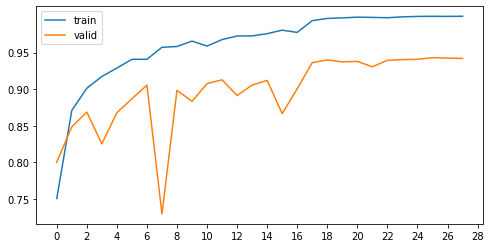

In [11]:
show_history(history)